## Imports

In [1]:
import os
import sys
import time
import feather
import numpy as np
import pandas as pd
from scipy import stats

os.environ["CUDA_VISIBLE_DEVICES"] = ""

from sklearn.preprocessing import scale
from sklearn.metrics import classification_report, matthews_corrcoef, \
    precision_recall_fscore_support, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

from keras.optimizers import SGD
from keras.layers import Dense, Input, concatenate, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import Model, load_model
import keras.backend as K
from keras.utils import to_categorical as onehot_encode
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import seaborn as sns

/Users/flynnb/local/anaconda3/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [60]:
def version(pkg):
    print(pkg.__name__, pkg.__version__)

import sklearn
import keras
version(np)
version(pd)
version(sklearn)
version(feather)
version(keras)
version(tf)

numpy 1.14.3
pandas 0.23.4
sklearn 0.20.0
feather 0.4.0
keras 2.1.5
tensorflow 1.0.0


## Model definitions and training functions

In [3]:
def create_model(input_size=10000, n_classes=33, 
                 layer_size_1=256, layer_size_2=128, layer_size_3=64,
                 dropout_rate_1=0.2, dropout_rate_2=0.2, dropout_rate_3=0.2,
                 **kwargs):
    expression_input = Input(shape=(input_size,))
    X = Dropout(dropout_rate_1)(expression_input)
    
    X = Dense(layer_size_1, activation='relu')(X)
    X = BatchNormalization(axis=1)(X)

    X = Dense(layer_size_2, activation='relu')(X)
    X = BatchNormalization(axis=1)(X)

    X = Dense(layer_size_3, activation='relu')(X)
    X = BatchNormalization(axis=1)(X)
    
    X = Dropout(dropout_rate_2)(X)    
    mlp_output = Dense(n_classes, activation='sigmoid')(X)

    model = Model(expression_input, mlp_output)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['categorical_accuracy'])
    
    return model

In [4]:
def _find_tumor_specific_features(exp, labels, tumor_type):
    labels = labels.reset_index(drop=True)
    exp = exp.reset_index(drop=True)
    tumor_samples = exp.loc[labels[labels == tumor_type].index, :]
    other_samples = exp.loc[labels[labels != tumor_type].index, :]
    print(f"Type: {tumor_type},  {tumor_samples.shape[0]} vs {other_samples.shape[0]}.")

    logFC = tumor_samples.mean() - other_samples.mean()
    pvalue = stats.ttest_ind(tumor_samples, other_samples, axis=0)[1]

    results = pd.DataFrame(np.vstack((logFC, pvalue)).T,
                           index=exp.columns,
                           columns=['logFC', 'pvalue'])
    results = results[results.pvalue < 0.001]
    return results.sort_values('logFC', ascending=False)

def select_features_per_class(training_data, training_labels, n_feats=50):
    classes = np.unique(training_labels)
    print(f"Selecting {n_feats} features for each of the {len(classes)} classes:")
    selected_features = set()
    print(classes)
    for tumor_type in classes:
        tumor_features = _find_tumor_specific_features(training_data, 
                                                       training_labels, 
                                                       tumor_type)
        print(tumor_features.head(3))
        print()
        selected_features |= set(tumor_features.index.tolist()[:n_feats])

    selected_features = list(selected_features)
    print(f"Using total of {len(selected_features)} features.")
    return selected_features

In [5]:
def train_and_evaluate(model,
                       training_data, training_labels,
                       testing_data, testing_labels,
                       only_fit=False,
                       **fit_kwargs):
    
    fit_params = dict(epochs = 10,
                      batch_size = 128,
                      validation_split = 0.2,
                      shuffle = True,
                      verbose = True)
    fit_params.update(fit_kwargs)
    
    h = model.fit(training_data, training_labels,
                  **fit_params)
    if only_fit:
        return

    score = model.evaluate(testing_data, testing_labels, verbose=True)
    print(score)
    preds = model.predict(testing_data, batch_size=fit_params.get('batch_size'))
    return preds

In [6]:
def tune_parameters(training_data, testing_data,
                    training_labels, testing_labels):
    grid_params = dict(layer_size_1 = np.exp2(range(6, 11)).astype(int),
                       layer_size_2 = np.exp2(range(5, 9)).astype(int),
                       dropout_rate_1 = [0.2],#np.arange(0.1, 0.6, 0.1).tolist(),
                       dropout_rate_2 = [0.2],#np.arange(0.1, 0.6, 0.1).tolist(),
                       n_classes = [33],
                       input_size = [training_data.shape[1]],
                       batch_size = [64]
                      )
    print(grid_params)
    
    model = KerasClassifier(build_fn=create_model, epochs=10, verbose=True)
    
    grid = GridSearchCV(estimator=model, param_grid=grid_params, n_jobs=1)
    
    grid_results = grid.fit(training_data, training_labels)
    
    return grid_results

In [7]:
def output_summary(model_output, labels):
    """
    Prints both 
    a.  cross-tabulation of classifications vs. true labels,
    b.  accuracy, precision, f score metrics summary per class
    """
    largest_excitation = np.argmax(model_output, axis=1)
    if isinstance(labels, list):
        labels = np.array(labels)
    
    classes = np.unique(labels)
    predicted = classes[largest_excitation]
    tab = pd.crosstab(predicted, labels)
    print(tab)
    print(matthews_corrcoef(predicted, labels))
    for arr, lab in zip(precision_recall_fscore_support(predicted, labels),
                        ('precision', 'recall', 'fscore')):
        print(lab, np.median(arr) * 100)
    print('specificity', np.median([sum(np.all(np.vstack((predicted, labels)) != k, axis=0)) / sum(predicted != k)
                                    for k in np.unique(labels)]) * 100)
    
    return classification_report(labels, predicted)

In [31]:
def perf_metrics(truth, pred):
    cnf_matrix = confusion_matrix(truth, pred)
    print(cnf_matrix)
    #[[1 1 3]
    # [3 2 2]
    # [1 3 1]]

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    res = {}
    # Sensitivity, hit rate, recall, or true positive rate
    res["TPR"] = TP/(TP+FN)
    # Specificity or true negative rate
    res["TNR"] = TN/(TN+FP) 
    # Precision or positive predictive value
    res["PPV"] = TP/(TP+FP)
    # Negative predictive value
    res["NPV"] = TN/(TN+FN)
    # Fall out or false positive rate
    res["FPR"] = FP/(FP+TN)
    # False negative rate
    res["FNR"] = FN/(TP+FN)
    # False discovery rate
    res["FDR"] = FP/(TP+FP)
    # Overall accuracy
    res["ACC"] = (TP+TN)/(TP+FP+FN+TN)
    return res

In [45]:
def score_external_validation(model, expression, annotations, labels=labels,
                              print_full=False, has_combined=True,
                              plot=False, support_threshold=1):

    prediction_inds = np.argmax(full_model.predict(expression.values), axis=1)
    prediction = np.unique(labels)[prediction_inds]

    if has_combined:
        combined_types = {'LUAD': 'LUAD/LUSC',
                          'LUSC': 'LUAD/LUSC',
                          'LGG': 'LGG/GBM',
                          'GBM': 'LGG/GBM',
                          "KIRC": "KIRC/KIRP/KIRH",
                          "KIRP": "KIRC/KIRP/KIRH",
                          "KIRH": "KIRC/KIRP/KIRH"}
        prediction = np.array([combined_types.get(pred, pred) for pred in prediction])
    
    truth = annotations.symbol.values
    
    index = sorted(list(set(np.unique(prediction)) | set(np.unique(truth))))
    columns = ["precision", "recall", "fscore", "support"]
    report = pd.DataFrame(np.vstack(precision_recall_fscore_support(truth, prediction)).T,
                          index=index, columns=columns)
    report['balanced accuracy'] = balanced_accuracy_score(truth, prediction)
    #report = report.astype(dict(zip(columns, [float]*4 + [int])))
    print(report[report.support >= support_threshold].median(axis=0))
    print(accuracy_score(truth, prediction))
    print(precision_recall_fscore_support(truth, prediction, average='macro'))
    res = perf_metrics(truth, prediction)
    print(np.mean(res["TPR"]))

    if print_full and annotations.columns.isin(["primary"]).any():
        for item in sorted(zip(annotations.primary, annotations.symbol, prediction)):
            print(item)
    
    if plot:
        matrix = pd.crosstab(truth, prediction)
        fig, ax = plt.subplots(dpi=200)
        sns.heatmap(matrix / matrix.sum(axis=0), ax=ax, square=True, cmap='magma_r', 
                    xticklabels=matrix.columns, yticklabels=matrix.index)
        ax.grid(ls=':', lw=0.5, alpha=0.5)
    
    return report[report.support > 0], pd.crosstab(truth, prediction), res

## Data loading and preprocessing

In [11]:
scale?

In [20]:
x = pd.DataFrame(np.random.rand(10, 10))

In [21]:
np.allclose(x.apply(lambda z: scale(z.values)).values, scale(x.values))

True

In [22]:
data_dir = os.path.abspath('./tcga_subtype_classification/data/external/')
exp_file = 'tcga_expression.csv'
anns_file = 'tcga_labels.csv'

exp = pd.read_csv(os.path.join(data_dir, exp_file), index_col=0).T
exp = exp.apply(lambda z: scale(z.values))
scaled_exp = scale(exp.values)
sample_anns = pd.read_csv(os.path.join(data_dir, anns_file), index_col=0)
sample_anns.columns = ['primary']

In [23]:
external_data_dir = "./tcga_subtype_classification/data/external/"

metastatic_exp = pd.read_csv(os.path.join(external_data_dir, "gse18549_expression.csv"), index_col=0).T
metastatic_exp = metastatic_exp.apply(lambda z: scale(z.values))
metastatic_anns = pd.read_csv(os.path.join(external_data_dir, "gse18549_primary_labels.csv"), index_col=0)
metastatic_anns.index = metastatic_exp.index
metastatic_anns.columns = ['primary']

In [24]:
microarray_exp = pd.read_csv(os.path.join(external_data_dir, "gse2109_expression.csv"), index_col=0).T
microarray_exp = microarray_exp.apply(lambda z: scale(z.values))
microarray_anns = pd.read_csv(os.path.join(external_data_dir, "gse2109_primary_labels.csv"), index_col=0)
microarray_anns.index = microarray_exp.index
microarray_anns.columns = ['primary']

In [25]:
xenograft_exp = pd.read_csv(os.path.join(external_data_dir, "pdx_expression.csv"), index_col=0).T
xenograft_exp = xenograft_exp.apply(lambda z: scale(z.values))
xenograft_anns = pd.read_csv(os.path.join(external_data_dir, "pdx_primary_labels.csv"), index_col=0)
xenograft_anns.index = xenograft_exp.index
xenograft_anns.columns = ['primary']

In [26]:
exp = exp.loc[:, metastatic_exp.columns.str.slice(1).astype(int)]

In [27]:
exp.shape

(9642, 8182)

In [28]:
labels = sample_anns['primary'].astype('category')
labels_int = labels.cat.codes.values
labels_one_hot = onehot_encode(labels_int)

In [29]:
class_weights = pd.value_counts(labels_int, normalize=True).sort_index().to_dict()

## Grid search - Run previously

In [11]:
data_split = train_test_split(exp, labels_one_hot, test_size=0.20, random_state=42)
print(list(map(lambda x: x.shape, data_split)))

[(7713, 10951), (1929, 10951), (7713, 33), (1929, 33)]


In [56]:
grid_results = tune_parameters(*data_split)

{'layer_size_1': array([  64,  128,  256,  512, 1024]), 'layer_size_2': array([ 32,  64, 128, 256]), 'dropout_rate_1': [0.2], 'dropout_rate_2': [0.2], 'n_classes': [33], 'input_size': [10951], 'batch_size': [64]}
Epoch 1/10
4306/4306 [==============================] - 24s 5ms/step - loss: 2.8640 - acc: 0.6217
Epoch 2/10
4306/4306 [==============================] - 2s 568us/step - loss: 2.4923 - acc: 0.7517
Epoch 3/10
4306/4306 [==============================] - 2s 576us/step - loss: 1.7148 - acc: 0.6953
Epoch 4/10
4306/4306 [==============================] - 2s 531us/step - loss: 1.2008 - acc: 0.7343
Epoch 5/10
4306/4306 [==============================] - 3s 585us/step - loss: 1.0347 - acc: 0.7480
Epoch 6/10
4306/4306 [==============================] - 3s 607us/step - loss: 0.8550 - acc: 0.7866
Epoch 7/10
4306/4306 [==============================] - 3s 609us/step - loss: 0.7570 - acc: 0.8047
Epoch 8/10
4306/4306 [==============================] - 3s 610us/step - loss: 0.7084 - acc: 0.8

4307/4307 [==============================] - 2s 557us/step - loss: 0.3373 - acc: 0.9315
Epoch 8/10
4307/4307 [==============================] - 2s 549us/step - loss: 0.1978 - acc: 0.9587
Epoch 9/10
4307/4307 [==============================] - 3s 616us/step - loss: 0.0970 - acc: 0.9779
Epoch 10/10
4307/4307 [==============================] - 2s 393us/step
Epoch 1/10
4306/4306 [==============================] - 25s 6ms/step - loss: 2.7940 - acc: 0.7030
Epoch 2/10
4306/4306 [==============================] - 3s 629us/step - loss: 2.2299 - acc: 0.7538
Epoch 3/10
4306/4306 [==============================] - 3s 615us/step - loss: 1.3047 - acc: 0.7120
Epoch 4/10
4306/4306 [==============================] - 3s 666us/step - loss: 0.9294 - acc: 0.7868
Epoch 5/10
4306/4306 [==============================] - 3s 662us/step - loss: 0.6765 - acc: 0.8344
Epoch 6/10
4306/4306 [==============================] - 3s 704us/step - loss: 0.5361 - acc: 0.8579
Epoch 7/10
4306/4306 [============================

4306/4306 [==============================] - 2s 376us/step
Epoch 1/10
4307/4307 [==============================] - 24s 6ms/step - loss: 2.7854 - acc: 0.7147
Epoch 2/10
4307/4307 [==============================] - 3s 618us/step - loss: 2.1966 - acc: 0.7221
Epoch 3/10
4307/4307 [==============================] - 3s 659us/step - loss: 1.2598 - acc: 0.7448
Epoch 4/10
4307/4307 [==============================] - 3s 641us/step - loss: 0.8615 - acc: 0.7889
Epoch 5/10
4307/4307 [==============================] - 3s 728us/step - loss: 0.7248 - acc: 0.8068
Epoch 6/10
4307/4307 [==============================] - 3s 693us/step - loss: 0.6765 - acc: 0.8159
Epoch 7/10
4307/4307 [==============================] - 3s 700us/step - loss: 0.6481 - acc: 0.8249
Epoch 8/10
4307/4307 [==============================] - 3s 622us/step - loss: 0.6203 - acc: 0.8461
Epoch 9/10
4307/4307 [==============================] - 2s 571us/step - loss: 0.4602 - acc: 0.8818
Epoch 10/10
4307/4307 [============================

4306/4306 [==============================] - 5s 1ms/step - loss: 0.3415 - acc: 0.9008
Epoch 9/10
4306/4306 [==============================] - 5s 1ms/step - loss: 0.3418 - acc: 0.8980
Epoch 10/10
4306/4306 [==============================] - 2s 408us/step
Epoch 1/10
4307/4307 [==============================] - 28s 7ms/step - loss: 2.3102 - acc: 0.7142
Epoch 2/10
4307/4307 [==============================] - 5s 1ms/step - loss: 1.1877 - acc: 0.7309
Epoch 3/10
4307/4307 [==============================] - 5s 1ms/step - loss: 0.6656 - acc: 0.8349
Epoch 4/10
4307/4307 [==============================] - 5s 1ms/step - loss: 0.4504 - acc: 0.8969
Epoch 5/10
4307/4307 [==============================] - 5s 1ms/step - loss: 0.2612 - acc: 0.9417
Epoch 6/10
4307/4307 [==============================] - 5s 1ms/step - loss: 0.1621 - acc: 0.9536
Epoch 7/10
4307/4307 [==============================] - 5s 1ms/step - loss: 0.1338 - acc: 0.9598
Epoch 8/10
4307/4307 [==============================] - 5s 1ms/ste

4306/4306 [==============================] - 11s 2ms/step - loss: 0.2452 - acc: 0.9399
Epoch 8/10
4306/4306 [==============================] - 11s 2ms/step - loss: 0.1558 - acc: 0.9561
Epoch 9/10
4306/4306 [==============================] - 11s 3ms/step - loss: 0.1332 - acc: 0.9587
Epoch 10/10
4306/4306 [==============================] - 2s 468us/step
Epoch 1/10
4307/4307 [==============================] - 35s 8ms/step - loss: 1.9501 - acc: 0.6682
Epoch 2/10
4307/4307 [==============================] - 11s 2ms/step - loss: 0.8191 - acc: 0.7762
Epoch 3/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.5938 - acc: 0.8187
Epoch 4/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.5453 - acc: 0.8326
Epoch 5/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.5066 - acc: 0.8419
Epoch 6/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.4121 - acc: 0.8821
Epoch 7/10
4307/4307 [==============================] - 10

4307/4307 [==============================] - 36s 8ms/step - loss: 1.9843 - acc: 0.6378
Epoch 2/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.9294 - acc: 0.7592
Epoch 3/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.7325 - acc: 0.7978
Epoch 4/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.5897 - acc: 0.8447
Epoch 5/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.4192 - acc: 0.8832
Epoch 6/10
4307/4307 [==============================] - 11s 2ms/step - loss: 0.3656 - acc: 0.8978
Epoch 7/10
4307/4307 [==============================] - 11s 2ms/step - loss: 0.3118 - acc: 0.9097
Epoch 8/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.2949 - acc: 0.9148
Epoch 9/10
4307/4307 [==============================] - 11s 3ms/step - loss: 0.2792 - acc: 0.9213
Epoch 10/10
4307/4307 [==============================] - 2s 514us/step
Epoch 1/10
6460/6460 [==============================] - 29

In [62]:
grid_results.best_params_

{'batch_size': 64,
 'dropout_rate_1': 0.2,
 'dropout_rate_2': 0.2,
 'input_size': 10951,
 'layer_size_1': 256,
 'layer_size_2': 128,
 'n_classes': 33}

## Primary Model training

### Cross-validation

In [160]:
if 1:
    grid_results_best_params_ = {
        'batch_size': 64,
        'dropout_rate_1': 0.2,
        'dropout_rate_2': 0.2,
        #'input_size': 10951,
        'layer_size_1': 256,
        'layer_size_2': 128,
        'n_classes': 33}
else:
    grid_results_best_params_ = {}

In [ ]:
n_folds = 10

dummy_x = np.ones_like(labels_int)
predicted_labels = np.zeros_like(labels_one_hot)

input_size = exp.shape[1]
n_classes = len(labels.unique())

do_feature_selection = False

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
with tf.device('/cpu:0'):
    for k, (train_inds, test_inds) in enumerate(skf.split(dummy_x, labels_int)):
        np.random.shuffle(train_inds)
        np.random.shuffle(test_inds)
        if do_feature_selection:
            feat_inds = select_features_per_class(exp.iloc[train_inds], 
                                                  labels[test_inds])
        else:
            feat_inds = range(exp.shape[1])
        
        grid_results_best_params_.update(input_size=len(feat_inds))
        model = None # need to reset weights from previous folds
        model = create_model(**grid_results_best_params_)
        
        model.summary()
        
        train_data = exp.iloc[train_inds, feat_inds].values
        test_data = exp.iloc[test_inds, feat_inds].values
        print(train_data.shape)
        print(test_data.shape)

        preds = train_and_evaluate(model, train_data, labels_one_hot[train_inds],
                                   test_data, labels_one_hot[test_inds],
                                   epochs=100 if do_feature_selection else 25, batch_size=16,
                                   class_weight=class_weights)
        predicted_labels[test_inds] = preds
        model.save("model_{}-fold_{}".format(n_folds, k))
        np.save("model-predicted-labels_{}-fold_{}.npz".format(n_folds, k), predicted_labels)

In [ ]:
report = output_summary(predicted_labels, labels)

In [ ]:
print(report)

### Full Model

In [175]:
# fit full model
with tf.device('/cpu:0'):
    train_inds = np.arange(exp.shape[0])
    np.random.shuffle(train_inds)

    grid_results_best_params_.update(input_size=exp.shape[1])
    
    full_model = create_model(**grid_results_best_params_)
    full_model.summary()
        
    train_data = exp.iloc[train_inds,:].values

    _ = train_and_evaluate(full_model, train_data, labels_one_hot[train_inds],
                           None, None, batch_size=16, only_fit=True,
                           epochs=25, class_weight=class_weights)
    full_model.save("full_model.h5".format(n_folds, k))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 8182)              0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 8182)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 256)               2094848   
_________________________________________________________________
batch_normalization_67 (Batc (None, 256)               1024      
_________________________________________________________________
dense_90 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_68 (Batc (None, 128)               512       
_________________________________________________________________
dense_91 (Dense)             (None, 64)                8256      
__________

# External Validation

In [38]:
# use gcloud model
full_model = load_model("full_model.h5")

In [35]:
microarray_anns.symbol.value_counts()

AttributeError: 'DataFrame' object has no attribute 'symbol'

In [39]:
ANNS_MAPPING = {
    'ovary': 'OV', 'omentum': 'OV', 'fallopian': 'OV', 'ovarian': 'OV',
    'bladder': 'BLCA',
    "breast": "BRCA",
    "colon": "COAD",
    "esophag": "ESCA",
    "kidney": "KIRC/KIRP/KIRH",
    "renal": "KIRC/KIRP/KIRH",
    "brain": "LGG/GBM",
    "liver": "LIHC",
    "lung": "LUAD/LUSC",
    "pancreas": "PAAD",
    "prostate": "PRAD",
    "testic": "TGCT",
    "neck": "HNSC",
    'thyroid': 'THCA',
    "marrow": "LAML",
    "b-cell": "DLBC",
    "rectum": "READ",
    "rectal": "READ",
    "skin": "SKCM",
    "soft": "SARC",
    "bone": "SARC",
}

def label_fix(anns):
    anns["symbol"] = "unknown"
    anns.primary = anns.primary.str.lower()
    for key, value in ANNS_MAPPING.items():
        anns.loc[anns.primary.str.contains(key), "symbol"] = value
    return anns

In [40]:
# fix labels
metastatic_anns = label_fix(metastatic_anns)
microarray_anns = label_fix(microarray_anns)
xenograft_anns = label_fix(xenograft_anns)

In [41]:
metastatic_anns.symbol.value_counts()

COAD              35
BRCA              14
OV                14
LUAD/LUSC         10
PRAD               9
KIRC/KIRP/KIRH     6
unknown            4
READ               2
ESCA               1
PAAD               1
Name: symbol, dtype: int64

In [42]:
xenograft_anns.symbol.value_counts()

LUAD/LUSC         88
COAD              68
SARC              49
BRCA              41
BLCA              29
SKCM              18
PAAD              12
READ               9
KIRC/KIRP/KIRH     8
OV                 7
LGG/GBM            5
unknown            4
Name: symbol, dtype: int64

precision              0.996139
recall                 0.997549
fscore                 0.991304
support              259.000000
balanced accuracy      0.981466
dtype: float64
0.9903546981953951
(0.987325269857138, 0.9814664317784776, 0.983625705357674, None)
[[  79    0    0 ...    0    0    0]
 [   0  407    0 ...    0    0    0]
 [   0    1 1092 ...    0    0    0]
 ...
 [   0    0    0 ...  175    0    0]
 [   0    0    0 ...    0   57    0]
 [   0    0    0 ...    0    0   80]]
0.9814664317784776


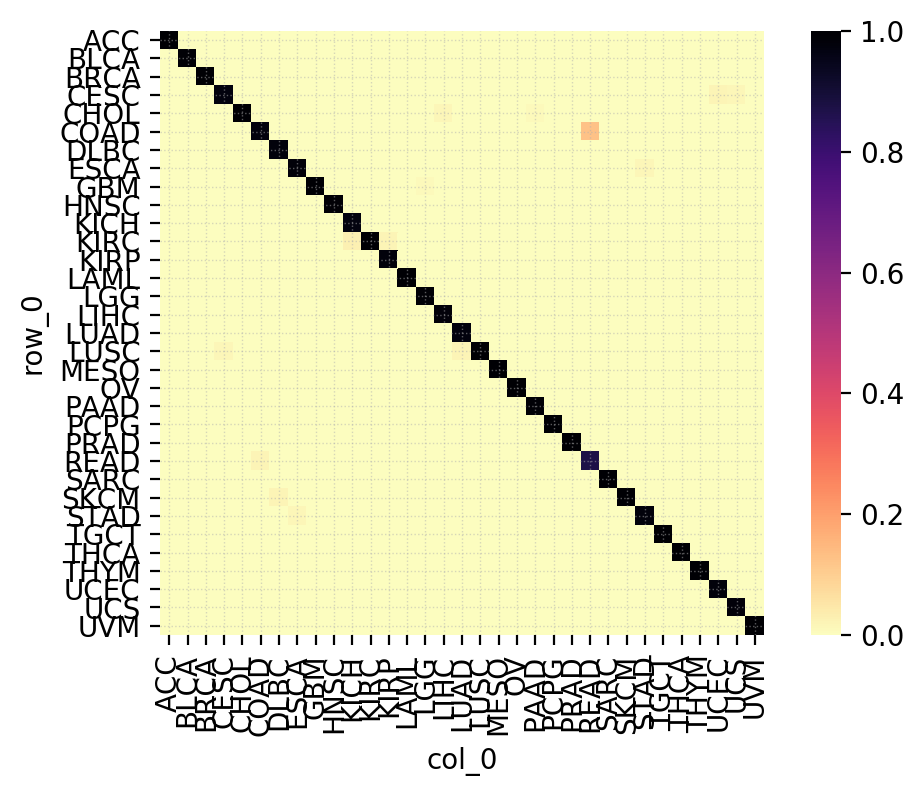

In [48]:
test = sample_anns.copy()
test["symbol"] = test.primary
report, crosstab, res = score_external_validation(full_model, exp, test,
                          labels, has_combined=False, plot=True)

In [55]:
full_metrics = pd.DataFrame.from_dict(res)
full_metrics.index = sorted(np.unique(labels))

In [57]:
full_metrics.to_csv('mlp/mlp_performance_metrics.csv')

In [44]:
crosstab.to_csv('mlp/mlp_performance_table.csv')

In [46]:
score_external_validation(full_model, metastatic_exp, metastatic_anns, labels, print_full=True,
                          support_threshold=5)
score_external_validation(full_model, xenograft_exp, xenograft_anns, labels, print_full=False)
score_external_validation(full_model, microarray_exp, microarray_anns, labels, print_full=False)

precision             0.900000
recall                0.766667
fscore                0.782214
support              12.000000
balanced accuracy     0.529048
dtype: float64
0.5104166666666666
(0.25656565656565655, 0.24047619047619048, 0.2346634023410327, None)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0 14  0  0  0  0  0  3  2  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

(                precision    recall    fscore  support  balanced accuracy
 BLCA             0.019108  0.093750  0.031746     32.0            0.05215
 BRCA             0.358108  0.149718  0.211155    354.0            0.05215
 COAD             0.071429  0.003205  0.006135    312.0            0.05215
 ESCA             0.000000  0.000000  0.000000      9.0            0.05215
 HNSC             0.000000  0.000000  0.000000      3.0            0.05215
 KIRC/KIRP/KIRH   0.100363  0.279461  0.147687    297.0            0.05215
 LGG/GBM          0.000000  0.000000  0.000000      6.0            0.05215
 LIHC             0.000000  0.000000  0.000000     46.0            0.05215
 LUAD/LUSC        0.026667  0.015038  0.019231    133.0            0.05215
 OV               0.000000  0.000000  0.000000    279.0            0.05215
 PAAD             0.000000  0.000000  0.000000     21.0            0.05215
 PRAD             0.004854  0.012048  0.006920     83.0            0.05215
 READ             0.00000

In [289]:
x = np.random.randint(0, 5, size=(5,5)).astype(int)

In [295]:
np.column_stack((x, scale(x, axis=0))).astype(int)

array([[ 4,  2,  4,  0,  2,  1,  0,  1, -1,  0],
       [ 4,  2,  1,  1,  1,  1,  0, -1,  0,  0],
       [ 2,  0,  3,  1,  4, -1, -1,  0,  0,  1],
       [ 3,  3,  1,  2,  0,  0,  0, -1,  1,  0],
       [ 2,  4,  4,  0,  0, -1,  1,  1, -1,  0]])

In [298]:
metastatic_exp.max().max()

9.746687558356987

In [303]:
metastatic_exp.iloc[[0,2,4,6],:].sum(axis=1)

GSM461711    330.026058
GSM461713     27.758566
GSM461715   -671.816786
GSM461717    -14.918229
dtype: float64

In [304]:
metastatic_exp.iloc[-4:,:].sum(axis=1)

GSM461803   -395.836640
GSM461804    296.818537
GSM461805    503.841798
GSM461806     11.335804
dtype: float64

## Why is OV categorically misclassified in external validations?

In [346]:
from sklearn.preprocessing import RobustScaler, normalize

In [361]:
metastatic_exp = pd.read_csv(os.path.join(external_data_dir, "gse18549_expression.csv"), index_col=0).T.values
metastatic_exp_scaled = scale(metastatic_exp)
metastatic_exp_robust = RobustScaler(quantile_range=(1.0, 99.0)).fit_transform(metastatic_exp)
metastatic_exp_normed = normalize(metastatic_exp)
metastatic_exp_scaled_normed = normalize(scale(metastatic_exp))

In [362]:
print(metastatic_exp.min().min(), metastatic_exp.max().max())
print(metastatic_exp_scaled.min().min(), metastatic_exp_scaled.max().max())
print(metastatic_exp_robust.min().min(), metastatic_exp_robust.max().max())
print(metastatic_exp_normed.min().min(), metastatic_exp_normed.max().max())
print(metastatic_exp_scaled_normed.min().min(), metastatic_exp_scaled_normed.max().max())

2.235332318 14.80440803
-6.866911617887796 9.74668755835699
-1.8930703738167562 18.56420883967938
0.004561312352165037 0.03377744185692901
-0.07099292895010813 0.15564070282916578


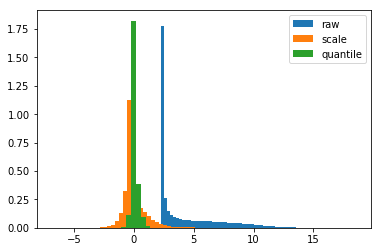

In [366]:
_ = plt.hist(metastatic_exp.flatten(), bins=50, normed=True, label='raw')
_ = plt.hist(metastatic_exp_scaled.flatten(), bins=50, normed=True, label='scale')
_ = plt.hist(metastatic_exp_robust.flatten(), bins=50, normed=True, label='quantile')
_ = plt.legend()

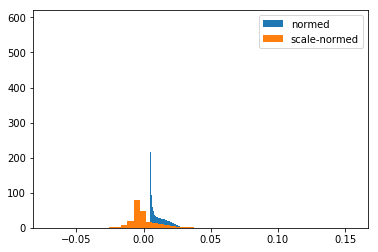

In [367]:
_ = plt.hist(metastatic_exp_normed.flatten(), bins=50, normed=True, label='normed')
_ = plt.hist(metastatic_exp_scaled_normed.flatten(), bins=50, normed=True, label='scale-normed')
_ = plt.legend()

In [368]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0).fit_transform(metastatic_exp)
pca_scaled = PCA(random_state=0).fit_transform(metastatic_exp_scaled)
pca_robust = PCA(random_state=0).fit_transform(metastatic_exp_robust)
pca_normed = PCA(random_state=0).fit_transform(metastatic_exp_normed)
pca_scaled_normed = PCA(random_state=0).fit_transform(metastatic_exp_scaled_normed)

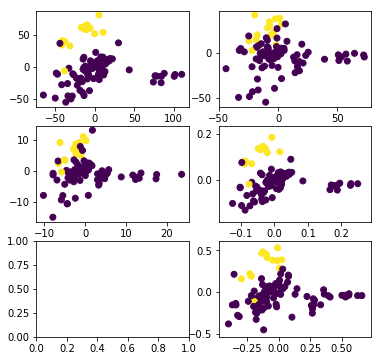

In [373]:
fig, axarr = plt.subplots(3, 2, figsize=(6, 6))
axarr[0,0].scatter(pca[:,1], pca[:,2], c=metastatic_anns.symbol == 'OV')
axarr[0,1].scatter(pca_scaled[:,1], -pca_scaled[:,2], c=metastatic_anns.symbol == 'OV')
axarr[1,0].scatter(pca_robust[:,1], -pca_robust[:,3], c=metastatic_anns.symbol == 'OV')
axarr[1,1].scatter(pca_normed[:,1], pca_normed[:,2], c=metastatic_anns.symbol == 'OV')
axarr[2,1].scatter(pca_scaled_normed[:,1], pca_scaled_normed[:,2], c=metastatic_anns.symbol == 'OV')

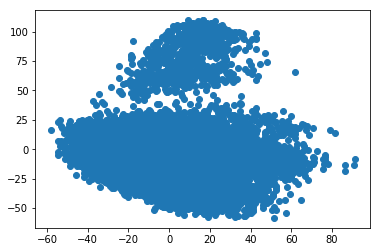

In [411]:
pca = PCA(random_state=0).fit_transform(np.vstack((scale(exp), scale(metastatic_exp))))


In [419]:
comb_labels = np.hstack((labels, metastatic_anns.symbol.values))

In [423]:
len(comb_labels[comb_labels == 'OV'])

317

In [425]:
sum(labels == 'OV')

303

In [432]:
inds = comb_labels == 'BRCA'

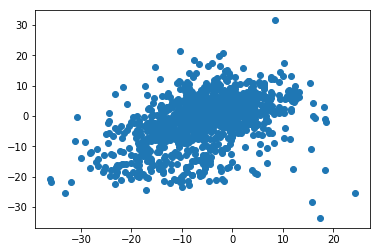

In [434]:
plt.scatter(pca[inds,0], pca[inds,2], alpha=1)

In [443]:
sample_anns.primary.value_counts()[::-1].cumsum() / sample_anns.primary.value_counts().sum()

CHOL    0.003734
DLBC    0.008712
UCS     0.014624
KICH    0.021469
ACC     0.029662
UVM     0.037959
MESO    0.046982
READ    0.056731
THYM    0.069177
TGCT    0.084733
GBM     0.100602
LAML    0.118544
UCEC    0.136797
PAAD    0.155258
PCPG    0.173823
ESCA    0.192906
SARC    0.219768
COAD    0.249326
KIRP    0.279403
OV      0.310828
CESC    0.342356
LIHC    0.380834
BLCA    0.423149
STAD    0.466190
SKCM    0.515038
PRAD    0.566584
THCA    0.618544
LUSC    0.670504
LUAD    0.723916
LGG     0.777432
HNSC    0.831363
KIRC    0.886642
BRCA    1.000000
Name: primary, dtype: float64

In [439]:
sample_anns.primary.value_counts().cumsum() / sample_anns.primary.value_counts().sum()

BRCA    0.113358
KIRC    0.168637
HNSC    0.222568
LGG     0.276084
LUAD    0.329496
LUSC    0.381456
THCA    0.433416
PRAD    0.484962
SKCM    0.533810
STAD    0.576851
BLCA    0.619166
LIHC    0.657644
CESC    0.689172
OV      0.720597
KIRP    0.750674
COAD    0.780232
SARC    0.807094
ESCA    0.826177
PCPG    0.844742
PAAD    0.863203
UCEC    0.881456
LAML    0.899398
GBM     0.915267
TGCT    0.930823
THYM    0.943269
READ    0.953018
MESO    0.962041
UVM     0.970338
ACC     0.978531
KICH    0.985376
UCS     0.991288
DLBC    0.996266
CHOL    1.000000
Name: primary, dtype: float64

In [442]:
8/33

0.24242424242424243